# **Lab 5: Differential equations**
**Lovisa Strange**

# **Abstract**

In this lab report, a time-stepping algorithm for solving differential equations and systems of differential equations are presented.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license.

In [ ]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2024 Lovisa Strange (lstrange@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them.

In [221]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
from scipy.optimize import fsolve
#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

A scalar initial value problem (IVP) is a differential equation $u(t)$ and an initial condition $u(0) = u_0.$ (Methods in Computational Science, Johan Hoffman, p.279) To solve the differential equation nummerically, we can use approximative methods. One such approximative method is time stepping, where approximations for discrete times $$
t_0=0, t_1, ...,t_{N-1}, t_N = T
$$
are computed after each other. We also set the initial condition as $U(t_0) = u_0.$ A time step is then the interval $[t_{n-1},t_n],$ with a step length of $h = t_n - t_{n-1}.$  

There are multiple ways to compute the approximation at time $t_n,$ for example using a forward difference approximation $$ \dot u(t_{n-1}) \approx \frac{u(t_n)-u(t_{n-1})}{h}.$$ This approximation gives the explicit Euler method $$
U_n = U_{n-1} + h f(U_{n-1},t_{n-1}).
$$

We can also use other difference approximations, for example a backwards difference approximation $$
\dot u(t_{n}) \approx \frac{u(t_n)-u(t_{n-1})}{h}.
$$
This gives the implicit Euler method $$
U_n = U_{n-1} + h f(U_{n},t_{n})
$$
and to solve this, we need to solve the equation $$
x = U_{n-1} + hf(x,t_n).
$$


There are also other variants of time stepping methods for differential equations. One example is the trapezoidal methof, which is given by itegrating a picewise linear interpolant to $f(u,t)$ in each timestep. Other time step methods can be constructed by combining two different time stepping methods.

We also know that the stability of a time stepping method depends both on the underlying  equation and on the time stepping method. (Methods in Computational Science, p.287) For the equation $$\dot u(t) = \lambda u(t), \;\; u(0) = 1, \;\; Re(λ) < 0 $$
we know that the explicit Euler method is stable for $$
|-1-kλ| < 1
$$
and implicit Euler is stable for $$
|1-kλ| > 1.
$$
The trapezoidal method is stable for $$
Re(0.5k\lambda) < 0
$$

For a system of first order initial value problems, we have that $$
\dot u = (\frac{du_1}{dt},...,\frac{du_N}{dt})^T,
$$
and $$
\dot u(t) = f(u(t),t), \;\; u(0) = u_0.
$$
The time stepping methods are defined in the same way as for scalar initial value problems.

# **Method**

##Time stepping for scalar initial value problem du/dt = f(u,t)

We can look at the solution to differential equations using integrals, as stated by the fundamental theorem of calculus. (Methods in Computational Science, p.282) Therefor, we can also use a nummerical approximation of an integral to solve create a time stepping method. By evaluating a function in the endpoints of the timestep, we get the methods implicit and explicit Euler, as well as the trapezoidal method.

Then, one algorithm using a parameter $θ$ can be used to do the time stepping for an initial value problem. We create the equation $$
U_{n+1} = U_{n} + h(1-\theta)f(U_{n+1},t_{n+1}) -h\theta f(U_n,t_n),
$$
which we can see gives the explicit Euler method for $θ = 1,$ the implicit Euler method for $θ = 0$ and the trapezoidal method for $\theta = 0.5$

For the implicit methods, we need to solve for $u_{n+1}$ in each time step.

The algorithom for this is shown below.

In [222]:
# Defining equation to be solved in each time step
def eq_scalar(vars,u0,theta,f,t,step):
  u = vars

  return u -u0 - step*(1-theta)*f(u,t) -step*theta*f(u0,t-step)

In [223]:
## Scalar initial value time stepping, based on algorithm from Methods in Computational Science, p.283

# Input: End-time T, function f(u,t), initial value u0 = u(0), method to use theta = one of (0,1,0.5), step length
# Output: Solution u in timesteps t_n interval [0,T]

def scalar_initial_value_time_stepping(T,f,u0, theta,step):
  t = 0
  u = [[0] for i in range(int(T/step)+1)] # result vector
  initial_val = u0

  count = 0
  while round(t,20) < T:
    u_new = fsolve(eq_scalar,u0,args=(u0,theta,f,t,step))
    u[count] = u_new
    u0 = u_new
    t = t + step
    count +=1

  u[0] = [initial_val] # set initial value

  return u

##Time stepping for system initial value problem du/dt = f(u,t)

The $\theta$ algorithm for a system of differential equations is the same, except for the fact that a system of non-linear equations need to be solved in each step. (Methods in Computational Science, p.289)

The algorithm for this is shown below.

In [224]:
# Defining system of equations to be solved in each time step

def eq_sys(vars,u0,theta,f,t,step):
  u1,u2 = vars
  f_val = f([u1,u2],t)
  f_val_0 =  f(u0,t-step)

  eq1 = u1 -u0[0] - step*(1-theta)*f_val[0] -step*theta*f_val_0[0]
  eq2  = u2 -u0[1] - step*(1-theta)*f_val[1] -step*theta*f_val_0[1]
  return [eq1,eq2]

In [225]:
## System initial value time stepping , based on algorithm from Methods in Computational Science, p.283

# Input: End-time T, function f(u,t), initial value u0 = u(0), method to use theta = one of (0,1,0.5), step length
# Output: Solution u in timesteps t_n interval [0,T]


def system_initial_value_time_stepping(T,f,u0,theta,step):
  t = 0

  u = [[0,0] for i in range(int(T/step)+1)]

  initial_val = u0

  count = 0
  while round(t,20) < T:
    u_new = fsolve(eq_sys,u0,args=(u0,theta,f,t,step))
    u[count] = u_new

    u0 = u_new
    t = t + step

    count += 1

  u[0] = initial_val # set initial value


  return u

# **Results**
In this section, the results produced by the algorithms in the previous section are presented

##Time stepping for scalar initial value problem du/dt = f(u,t)
We define a simple function of the correct form, $$
\frac{du}{dt} = u, \;\; u(0) = 1
$$
which has the exact solution
$$
u(t) = exp(t).
$$

In [226]:
def f(u,t):
  return u

The approximate solution for two different step lengths are compared in the figures below.

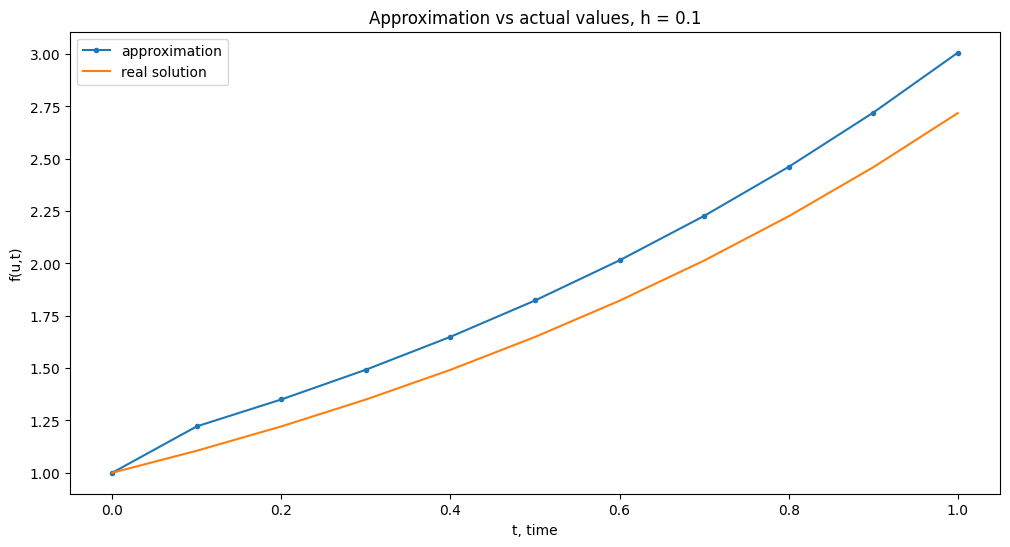

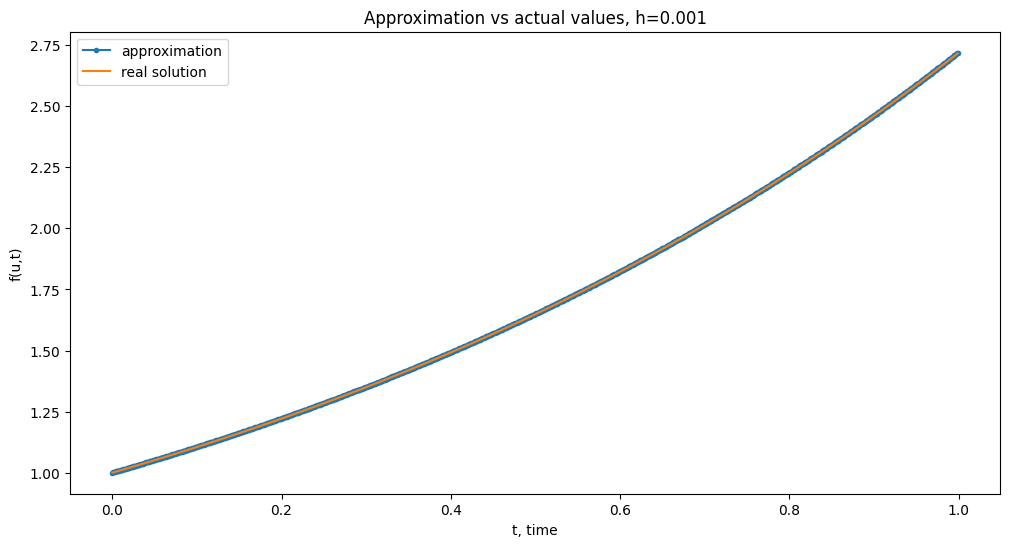

In [227]:
step = 0.1
y = scalar_initial_value_time_stepping(1,f,1,0.5,step)

if y[-1] == [0]:
  y = y[0:]
  x = [i*step for i in range(int(1/step))]
  y_real = [np.e**(i*step) for i in range(int(1/step))]
else:
  x = [i*step for i in range(int(1/step)+1)]
  y_real = [np.e**(i*step) for i in range(int(1/step)+1)]




plt.figure(figsize=(12,6))
plt.plot(x,y,'.-')
plt.plot(x,y_real)
plt.xlabel('t, time')
plt.ylabel('f(u,t)')
plt.legend(['approximation', 'real solution'])
plt.title('Approximation vs actual values, h = 0.1')


step = 0.001
y = scalar_initial_value_time_stepping(1,f,1,0.5,step)

if y[-1] == [0]:
  y = y[0:-1]
  x = [i*step for i in range(int(1/step))]
  y_real = [np.e**(i*step) for i in range(int(1/step))]
else:
  x = [i*step for i in range(int(1/step)+1)]
  y_real = [np.e**(i*step) for i in range(int(1/step)+1)]


plt.figure(figsize=(12,6))
plt.plot(x,y,'.-')
plt.plot(x,y_real)
plt.xlabel('t, time')
plt.ylabel('f(u,t)')
plt.legend(['approximation', 'real solution'])
plt.title('Approximation vs actual values, h=0.001')
plt.show()

As we can see, the approximate solution converges to the real solution when decreasing the step-size.

We can also look at the stability of the solution. We have the stable problem $$
\frac{du}{dt} = (-3)u, \;\; u(0) = 1
$$
which has the exact solution
$$
u(t) = exp(-3t).
$$
We know that using the explicit Euler method, the solution is stable if$$
|-1+3k| < 1.
$$
Therfore, using the step-length $h=1/3$ should give a stable solution, but using $h=3/4$ should give an unstable solution. This is checked below


In [228]:
def f2(u,t):
  return -3*u

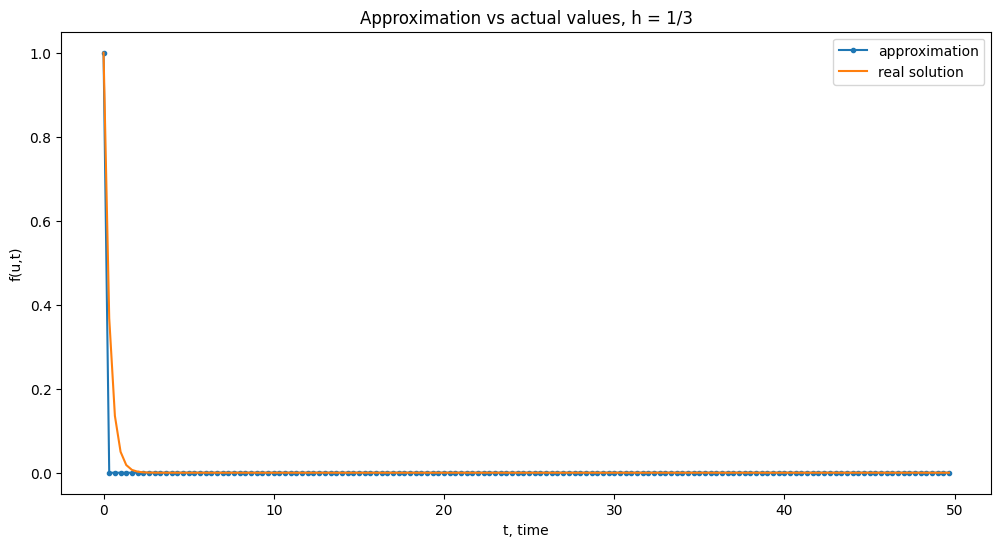

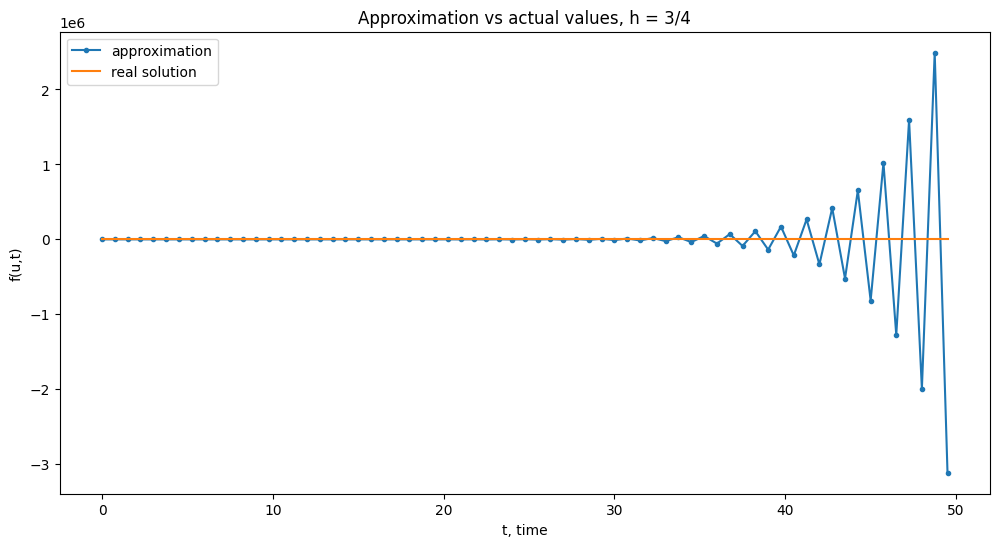

In [235]:
step = 1/3
T = 50
theta = 1
u0 = 1

y = scalar_initial_value_time_stepping(T,f2,u0,theta,step)
if y[-1] == [0]:
  y = y[0:-1]
  x = [i*step for i in range(int(T/step))]
  y_real = [np.e**(-3*i*step) for i in range(int(T/step))]
else:
  x = [i*step for i in range(int(1/step)+1)]
  y_real = [np.e**(-3*i*step) for i in range(int(T/step)+1)]
plt.figure(figsize=(12,6))
plt.plot(x,y,'.-')
plt.plot(x,y_real)
plt.xlabel('t, time')
plt.ylabel('f(u,t)')
plt.legend(['approximation', 'real solution'])
plt.title('Approximation vs actual values, h = 1/3')

step = 3/4
T = 50
theta = 1
u0 = 1

y = scalar_initial_value_time_stepping(T,f2,u0,theta,step)
if y[-1] == [0]:
  y = y[0:-1]
  x = [i*step for i in range(int(T/step))]
  y_real = [np.e**(-3*i*step) for i in range(int(T/step))]
else:
  x = [i*step for i in range(int(T/step)+1)]
  y_real = [np.e**(-3*i*step) for i in range(int(T/step)+1)]

plt.figure(figsize=(12,6))
plt.plot(x,y,'.-')
plt.plot(x,y_real)
plt.xlabel('t, time')
plt.ylabel('f(u,t)')
plt.legend(['approximation', 'real solution'])
plt.title('Approximation vs actual values, h = 3/4')
plt.show()

As we can see, the first value for the step length gives a good approximation of the solution, whilst the other step length quickly diverges from the real solution.



##Time stepping for system initial value problem du/dt = f(u,t)

For a system of differential equations, we can do the same analysis. We define the system $$
\begin{cases}
\dot u_1 = u_2 \\
\dot u_2 = -u_1
\end{cases}
$$
with initial conditions $u_1(0) = 1$ and $u_2(0) = 2.$

This system has the solution $$
\begin{cases}
u_1 = 2sin(t) + cos(t) \\
u_2 = 2cos(t)-sin(t)
\end{cases}
$$


In [236]:
def g(u,t):
  return [u[1], -u[0]]

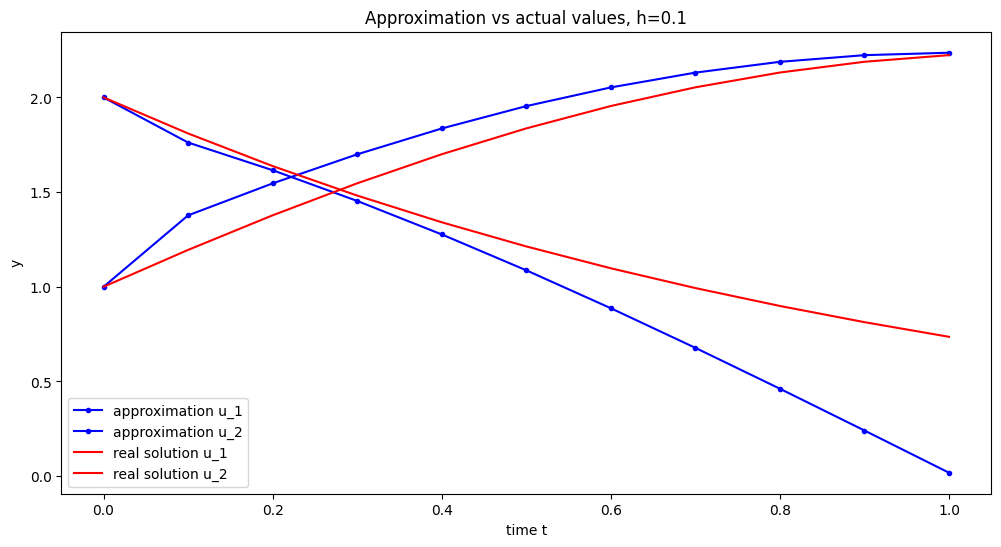

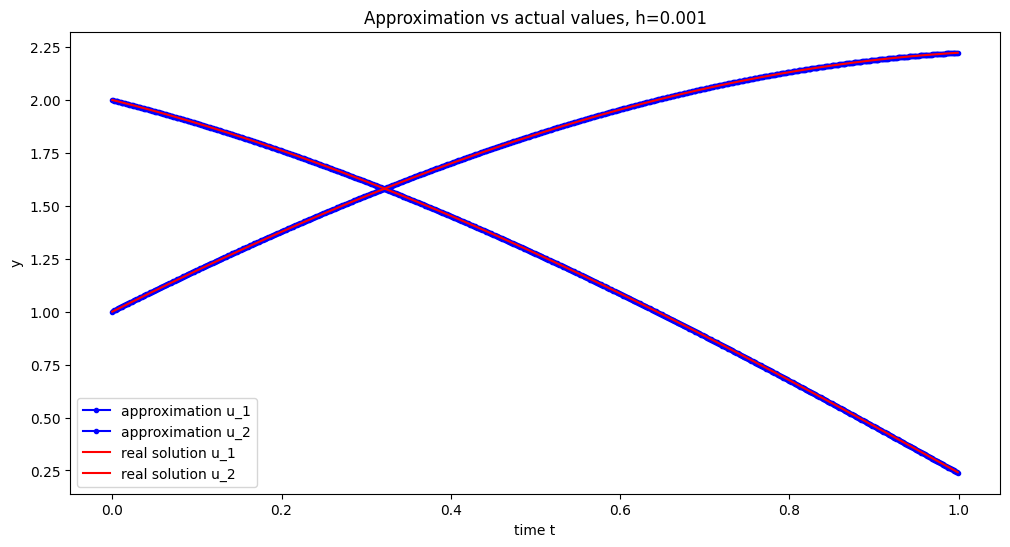

In [237]:
step = 0.1
T =1

y = system_initial_value_time_stepping(T,g,[1,2],0.5,step)

if y[-1].all() == 0:
  y = y[0:-1]
  x = [i*step for i in range(int(T/step))]
  y_real_1 = [np.cos(i*step)+np.sin(i*step)*2 for i in range(int(T/step))]
  y_real_2 = [2*np.cos(i*step)-np.sin(i*step) for i in range(int(T/step))]

else:
  x = [i*step for i in range(int(1/step)+1)]
  y_real_1 = [np.cos(i*step)+np.sin(i*step)*2 for i in range(int(1/step)+1)]
  y_real_2 = [2*np.e**(-i*step) for i in range(int(1/step)+1)]

y_1 = []
y_2 = []


for val in y:
  y_1.append(val[0])
  y_2.append(val[1])

plt.figure(figsize=(12,6))
plt.plot(x,y_1,'.-b')
plt.plot(x,y_2,'.-b')
plt.plot(x,y_real_1,'r')
plt.plot(x,y_real_2,'r')
plt.xlabel('time t')
plt.ylabel('y')
plt.legend(['approximation u_1', 'approximation u_2', 'real solution u_1', 'real solution u_2'])
plt.title('Approximation vs actual values, h=0.1')


step = 0.001
T =1

y = system_initial_value_time_stepping(T,g,[1,2],0.5,step)

if y[-1] == [0,0]:
  y = y[0:-1]
  x = [i*step for i in range(int(T/step))]
  y_real_1 = [np.cos(i*step)+np.sin(i*step)*2 for i in range(int(T/step))]
  y_real_2 = [2*np.cos(i*step)-np.sin(i*step) for i in range(int(T/step))]

else:
  x = [i*step for i in range(int(1/step)+1)]
  y_real_1 = [np.cos(i*step)+np.sin(i*step)*2 for i in range(int(1/step)+1)]
  y_real_2 = [2*np.e**(-i*step) for i in range(int(1/step)+1)]

y_1 = []
y_2 = []


for val in y:
  y_1.append(val[0])
  y_2.append(val[1])

plt.figure(figsize=(12,6))
plt.plot(x,y_1,'.-b')
plt.plot(x,y_2,'.-b')
plt.plot(x,y_real_1,'r')
plt.plot(x,y_real_2,'r')
plt.xlabel('time t')
plt.ylabel('y')
plt.legend(['approximation u_1', 'approximation u_2', 'real solution u_1', 'real solution u_2'])
plt.title('Approximation vs actual values, h=0.001')

plt.show()

As we can see, the approximate solution converges to the real solution when we decrease the step length.


And for the stability, we can do the same check as before. We have the system $$
\frac{du_1}{dt} = (-3)u_1, \;\; u(0) = 1
$$
$$
\frac{du_2}{dt} = (-3)u_2, \;\; u(0) = 1
$$
which has the exact solution
$$
u(t) = exp(-3t).
$$
$$
u(t) = exp(-2t).
$$
We know that using the explicit Euler method, the solution is stable if$$
|-1+3k| < 1
$$
and $$
|-1+3k| < 1.
$$
Therfore, using the step-length $h=1/4$ should give a stable solution, but using $h=2$ should give an unstable solution. This is checked below

In [232]:
def g2(u,t):
  return [-3*u[0], -2*u[1]]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]


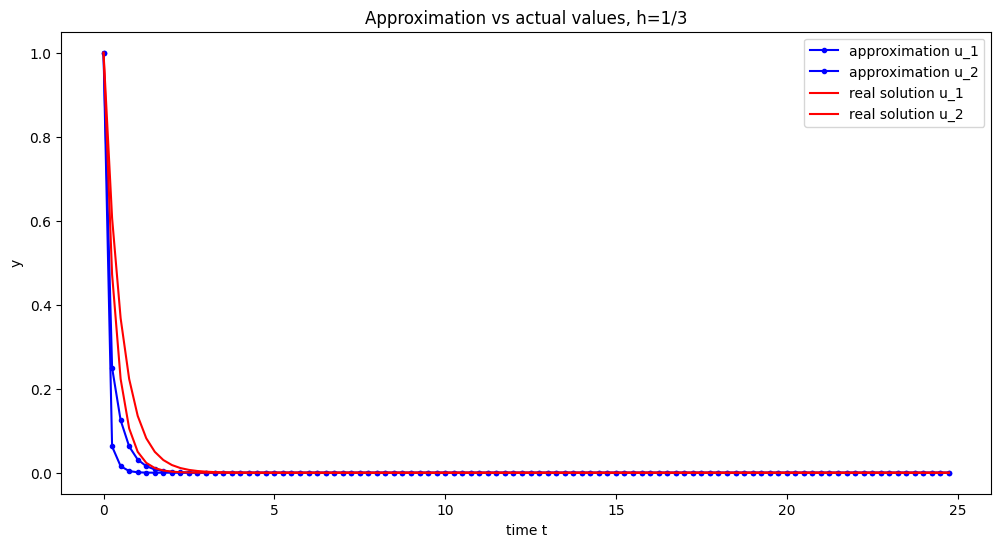

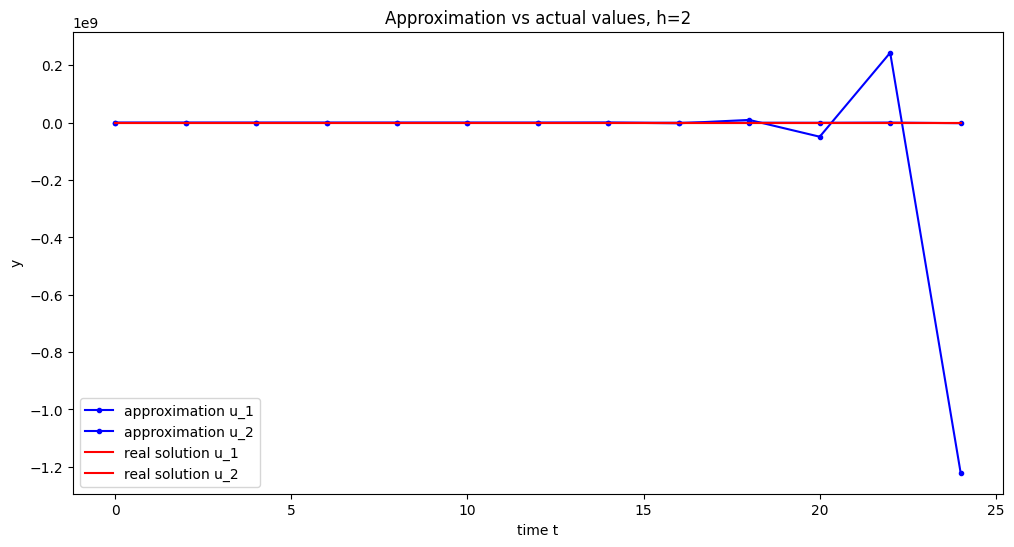

In [238]:
step = 1/4
T =25

y = system_initial_value_time_stepping(T,g2,[1,1],1,step)

if y[-1] == [0,0]:
  y = y[0:-1]
  x = [i*step for i in range(int(T/step))]
  y_real_1 = [np.e**(-3*i*step) for i in range(int(T/step))]
  y_real_2 = [np.e**(-2*i*step) for i in range(int(T/step))]

else:
  x = [i*step for i in range(int(1/step)+1)]
  y_real_1 = [np.e**(-3*i*step) for i in range(int(T/step)+1)]
  y_real_2 = [np.e**(-2*i*step) for i in range(int(T/step)+1)]

y_1 = []
y_2 = []


for val in y:
  y_1.append(val[0])
  y_2.append(val[1])

plt.figure(figsize=(12,6))
plt.plot(x,y_1,'.-b')
plt.plot(x,y_2,'.-b')
plt.plot(x,y_real_1,'r')
plt.plot(x,y_real_2,'r')
plt.xlabel('time t')
plt.ylabel('y')
plt.legend(['approximation u_1', 'approximation u_2', 'real solution u_1', 'real solution u_2'])
plt.title('Approximation vs actual values, h=1/3')


step = 2

y = system_initial_value_time_stepping(T,g2,[1,1],1,step)
if y[-1].all() == 0:
  y = y[0:-1]
  x = [i*step for i in range(int(T/step))]
  y_real_1 = [np.e**(-3*i*step) for i in range(int(T/step))]
  y_real_2 = [np.e**(-2*i*step) for i in range(int(T/step))]

else:
  x = [i*step for i in range(int(T/step)+1)]
  y_real_1 = [np.e**(-3*i*step) for i in range(int(T/step)+1)]
  y_real_2 = [np.e**(-2*i*step) for i in range(int(T/step)+1)]

y_1 = []
y_2 = []


for val in y:
  y_1.append(val[0])
  y_2.append(val[1])
print(x)

plt.figure(figsize=(12,6))
plt.plot(x,y_1,'.-b')
plt.plot(x,y_2,'.-b')
plt.plot(x,y_real_1,'r')
plt.plot(x,y_real_2,'r')
plt.xlabel('time t')
plt.ylabel('y')
plt.legend(['approximation u_1', 'approximation u_2', 'real solution u_1', 'real solution u_2'])
plt.title('Approximation vs actual values, h=2')

plt.show()

As we can see, the solution again diverges for $h=2,$ but converges to 0 when $h=1/4.$

# **Discussion**

The results for the solutions were mostly expected. The solutions were closer to the real solution the smaller the step-length, which was expected. Also, the stability of the solution for the model problem was as expected, since the solution diverged for step lengths not fulfilling the convergence criteria for the explicit Euler method.

Also, the precision of float numbers in Python affected the stopping criteria, which did not stop as expected. Therefore, the time was rounded to 20 decimal, which made the loop stop as expected.